## Mushrooms with Decisiontree
Homework for DataMining. Analyse mashroom dataset with decisiontree.
Click <a href="https://archive.ics.uci.edu/ml/datasets/mushroom">here</a> to know more about the dataset.
### Explore the dataset

In [67]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot') # Have a nicer style of the plotsdf
from sklearn import tree
import sklearn.metrics as metrics
from sklearn import model_selection
from IPython.display import Image  
import pydotplus
import graphviz

In [3]:
df = pd.read_csv('./mushroom.csv')

Let's check our df.

In [6]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [8]:
df.shape

(8124, 23)

Do we need to handle missing data?

In [7]:
pd.isnull(df).values.any()

False

Next, let's figure out what are the classes we have.

In [10]:
df['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

e is for edible, p is for poisonous
Now, let's check how many values each attribute has

In [13]:
[df[x].unique().shape[0] for x in df.columns]

[2, 6, 4, 10, 2, 9, 2, 2, 2, 12, 2, 5, 4, 4, 9, 9, 1, 4, 3, 5, 9, 6, 7]

Split the df into the targets and attributes, denoted by Y and X respectively.

In [16]:
Y = df['class']
X = df[df.columns[1:]]

We recommend to use dummies representation.

In [24]:
X_dummy = pd.get_dummies(X)
Y_dummy = Y.apply(lambda x: 1 if x=='e' else 0)

We can understand the structure of the dummy version of X by looking into a specific column. 
The bruises column has two possible categorical values:

In [25]:
df.bruises.unique()

array(['t', 'f'], dtype=object)

In turn, in X_dummy there are two columns related to df.bruises:
- X_dummy.bruises_t
- X_dummy.bruises_f
The entry in X_dummy corresponding to an entry in X that had t as the value for bruises will have 1 and 0 in the columns bruises_t and bruises_f, respectively.

OK, time to do some ML!

### Trees training

The first step is to split the dataset into training sets (independent data and target) and to testing sets. We first take the most naive approach, for training we will take the first 
n
 lines and for testing the rest.

In [29]:
def naive_split(X, Y, n):
    # Take first n lines of X and Y for training and the rest for testing
    X_train = X[:n]
    X_test  = X[n:]
    Y_train = Y[:n]
    Y_test  = Y[n:]
    return (X_train, X_test, Y_train, Y_test)

In [30]:
def train_model(n=7000):
    # Given X_dummy and Y_dummy, split naively into training and testing sets
    X_train, X_test, Y_train, Y_test = naive_split(X_dummy, Y_dummy, n)
    # Instantiate a default decision tree with fixed random state
    # NOTE: In real life you'd probably want to remove the fixed seed.
    clf = tree.DecisionTreeClassifier(random_state=42)
    # Next, train a default decision tree using the training sets
    clf = clf.fit(X_train, Y_train)
    # Lastly, return the test sets and the trained model
    return (X_test, Y_test, clf)

We will do an experiment with this training model. We will take traing set with increasing sizes and evaluate their accuracy, precisions and recals.

Text(0,0.5,'Value')

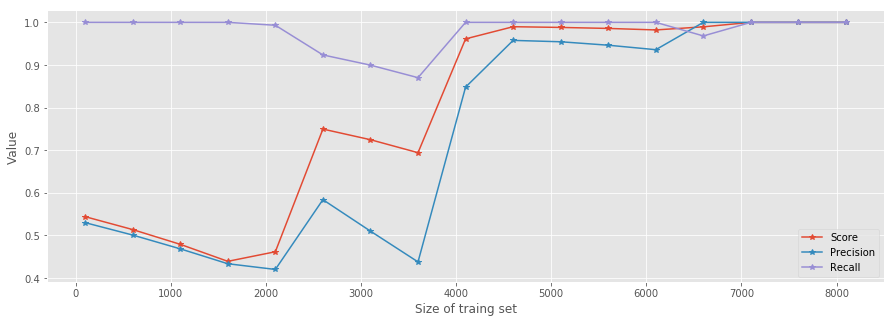

In [72]:
sizes = np.arange(100, len(Y_dummy), 500)
result = {}

for size in sizes:
    X_test, Y_test, clf = train_model(size)
    score = clf.score(X_test, Y_test)
    precision = metrics.precision_score(Y_test, clf.predict(X_test))
    recall = metrics.recall_score(Y_test, clf.predict(X_test))
    result[size] = (score, precision, recall)

result = pd.DataFrame(result).transpose()
result.columns = ['Score', 'Precision', 'Recall']
result.plot(marker='*', figsize=(15,5))
plt.xlabel('Size of traing set')
plt.ylabel('Value')

As you can see, the improvement is too bumpy. So next, we will try random generation of traning and testing sets. This can be easily done using the train_test_split method from the model_selection module.

In [43]:
def improved_train_model(size=0.01):
    # Given X_dummy and Y_dummy, split naively into training and testing sets
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_dummy, Y_dummy, test_size=size, random_state=42)
    # Instantiate a default decision tree with fixed random state
    # NOTE: In real life you'd probably want to remove the fixed seed.
    clf = tree.DecisionTreeClassifier(random_state=42)
    # Next, train a default decision tree using the training sets
    clf = clf.fit(X_train, Y_train)
    # Lastly, return the test sets and the trained model
    return (X_test, Y_test, clf)

Text(0,0.5,'Value')

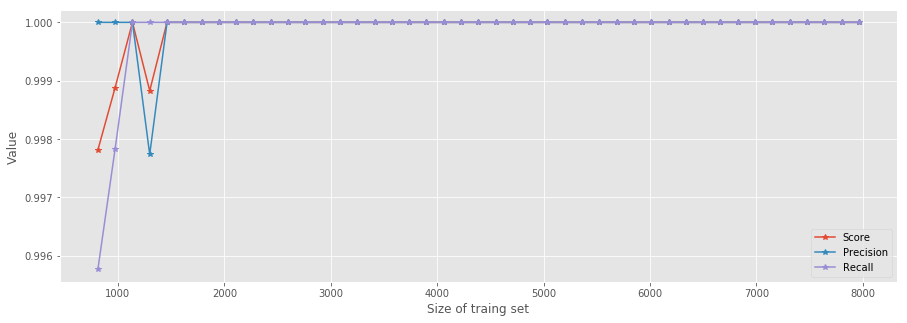

In [46]:
# This size represent the proportion of the dataset to include in the test split.
sizes = np.arange(0.9, 0.01, -0.02)
result = {}
for size in sizes:
    X_test, Y_test, clf = improved_train_model(size)
    score = clf.score(X_test, Y_test)
    precision = metrics.precision_score(Y_test, clf.predict(X_test))
    recall = metrics.recall_score(Y_test, clf.predict(X_test))
    result[8124-len(Y_test)] = (score, precision, recall)
    
result = pd.DataFrame(result).transpose()
result.columns = ['Score', 'Precision', 'Recall']
result.plot(marker='*', figsize=(15,5))
plt.xlabel('Size of traing set')
plt.ylabel('Value')

By simply counting the number of poisonous vs. edible mushrooms in the first 
n
-rows, we can indeed see that, at first, the dataset contains more edible samples.

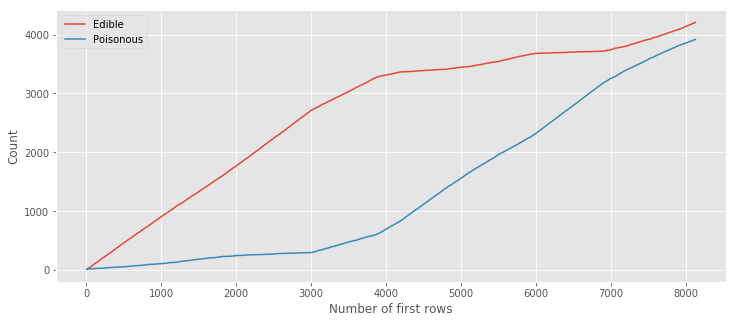

In [47]:
# Counting e(i) and p(i), the number of edible and poisonous mushrums up to the i-th row
e = []
p = []
for i in range(10,len(Y)):
    tmp = Y[:i].value_counts()
    e.append(tmp['e'])
    p.append(tmp['p'])
type_count = pd.DataFrame({'Edible': e, 'Poisonous': p},index=range(10,len(Y_dummy)))
type_count.plot(figsize=(12,5))
plt.xlabel('Number of first rows');
plt.ylabel('Count');

This image clearly shows us that the majority of samples up to the ~6000th line are edible. This can be better visualized (known as stacked area) as follows:

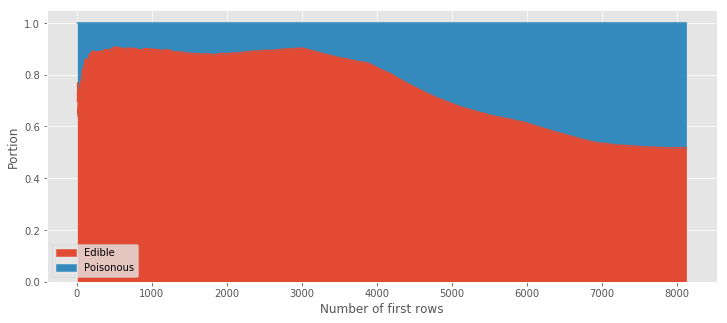

In [49]:
type_count.divide(type_count.sum(axis=1), axis=0).plot.area(figsize=(12,5))
plt.xlabel('Number of first rows')
plt.ylabel('Portion');

rom this visualization you can easily see that more than 
70
%
 of the first 
5000
 data points are edible. This order (or lack of randomness 🤔) explains why training the trees using the first 
n
 rows is a bad idea as it trains mostly using edible examples and fails to learn the characteristics of the poisonous ones. The take home message from this example: "take a random sub-sample for the training/test split".
 ### Tuning parameters
  It is now worthwhile to explore some of the parameters that can be tuned. To that end, let us naively take the first 2800 row for training and the rest for testing. The reason of choosing this number is that then we have room for improvement.

In [50]:
X_train, X_test, Y_train, Y_test = naive_split(X_dummy, Y_dummy, 2800)

Furthermore, we use the following simple function. As an input it takes a model's instance and training/testing sets. Next it computes the score, precision and recall of the model.

In [52]:
def test_tree(clf, X_train, X_test, Y_train, Y_test, print_res=True):
    clf       = clf.fit(X_train, Y_train)
    score     = clf.score(X_test, Y_test) # In the decision tree's classifier case it is the mean accuracy
    precision = metrics.precision_score(Y_test, clf.predict(X_test))
    recall    = metrics.recall_score(Y_test, clf.predict(X_test))
    res = (score, precision,recall)
    if print_res:
        print("Accuracy = %f / Precision = %f / Recall = %f" % res)
    return res

Furthermore, we use the following simple function. As an input it takes a model's instance and training/testing sets. Next it computes the score, precision and recall of the model.                                                                    
Let's recall what's the performance of the model using the defaults (for the sake of clarity, the defaults are explicitly stated).

In [54]:
clf = tree.DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=42, # we override the default here for the sake of reproducibility
    max_leaf_nodes=None, 
    min_impurity_decrease=1e-07, 
    class_weight=None, 
    presort=False)
test_tree(clf, X_train, X_test, Y_train, Y_test);

Accuracy = 0.740045 / Precision = 0.555077 / Recall = 0.914843


#### max_features parameter
The number of features we have in our dataset equals the number of dummy features. We will now look into the influence of this parameter on the performance of the trained trees. We will iterate over all the possible values for this parameter while keeping all the other parameters fixed to their defaults.

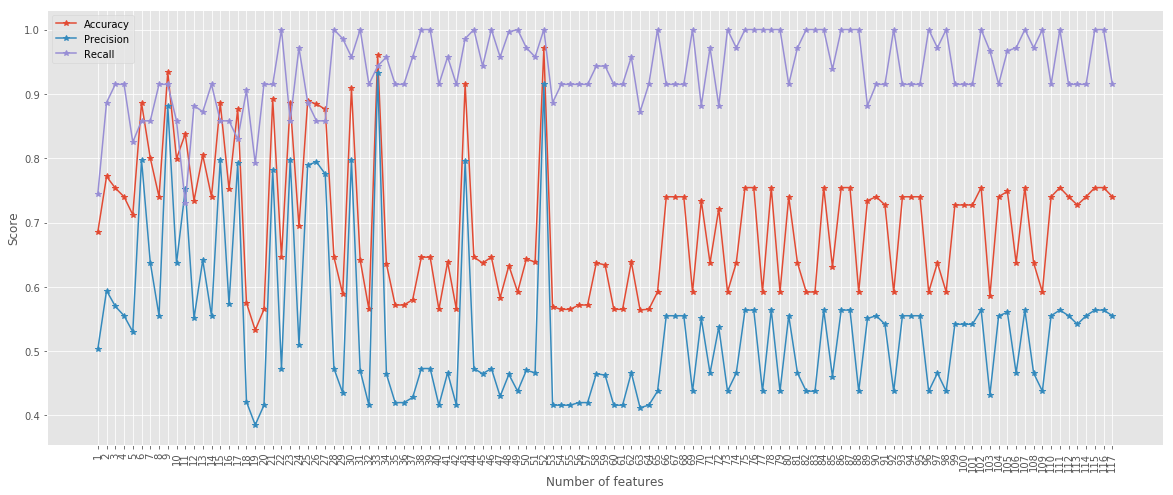

In [56]:
score = []
precision = []
recall = []
index = np.arange(1,X_dummy.shape[1]+1)
for i in index:
    clf = tree.DecisionTreeClassifier(
        criterion='gini', 
        splitter='best', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, 
        max_features=i, 
        random_state=42, # we override the default here for the sake of reproducibility
        max_leaf_nodes=None, 
        min_impurity_decrease=1e-07, 
        class_weight=None, 
        presort=False)
    tmp = test_tree(clf, X_train, X_test, Y_train, Y_test, print_res=False)
    score.append(tmp[0])
    precision.append(tmp[1])
    recall.append(tmp[2])

pd.DataFrame({'Accuracy': score, 'Precision': precision, 'Recall': recall}, index=index).plot(figsize=(20,8), marker='*')
plt.xticks(index, rotation=90)
plt.xlabel('Number of features')
plt.ylabel('Score');

Interestingly, tuning the max_features parameter can help us train a better model even without shuffling of the data. With max_features = 52 all metrics are above 
0.9
. Remember that this is using the naive splitting for training and testing! The take home message here is: default settings are nice but can be improved.
#### max_depth

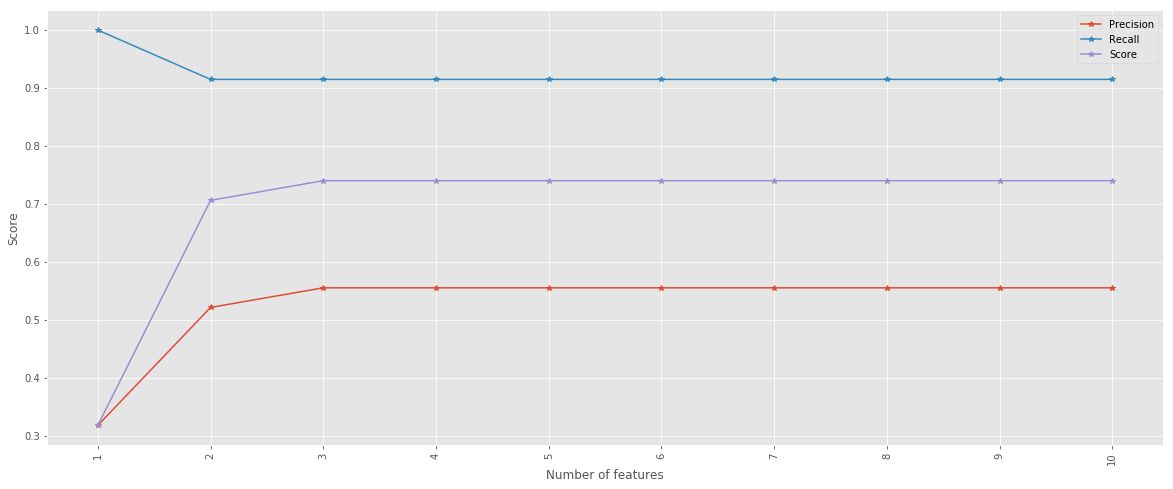

In [58]:
score = []
precision = []
recall = []
index = range(1,11)
for i in index:
    clf = tree.DecisionTreeClassifier(
        criterion='gini', 
        splitter='best', 
        max_depth=i, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, 
        max_features=None, 
        random_state=42, # we override the default here for the sake of reproducibility
        max_leaf_nodes=None, 
        min_impurity_decrease=1e-07, 
        class_weight=None, 
        presort=False)
    tmp = test_tree(clf, X_train, X_test, Y_train, Y_test, print_res=False)
    score.append(tmp[0])
    precision.append(tmp[1])
    recall.append(tmp[2])

pd.DataFrame({'Score': score, 'Precision': precision, 'Recall': recall}, index=index).plot(figsize=(20,8), marker='*')
plt.xticks(index, rotation=90)
plt.xlabel('Number of features')
plt.ylabel('Score');

### Visualize the tree
To the end, we split the dataset and keep 75% for testing purpose 25% for training purpose. Next, we train the dataset with our two tuned parameters max_features=52 max_depth=5.

In [63]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
        X_dummy, Y_dummy, test_size=0.75, random_state=42)
clf = tree.DecisionTreeClassifier(random_state=42, max_depth=5, max_features=52)
clf = clf.fit(X_train, Y_train)

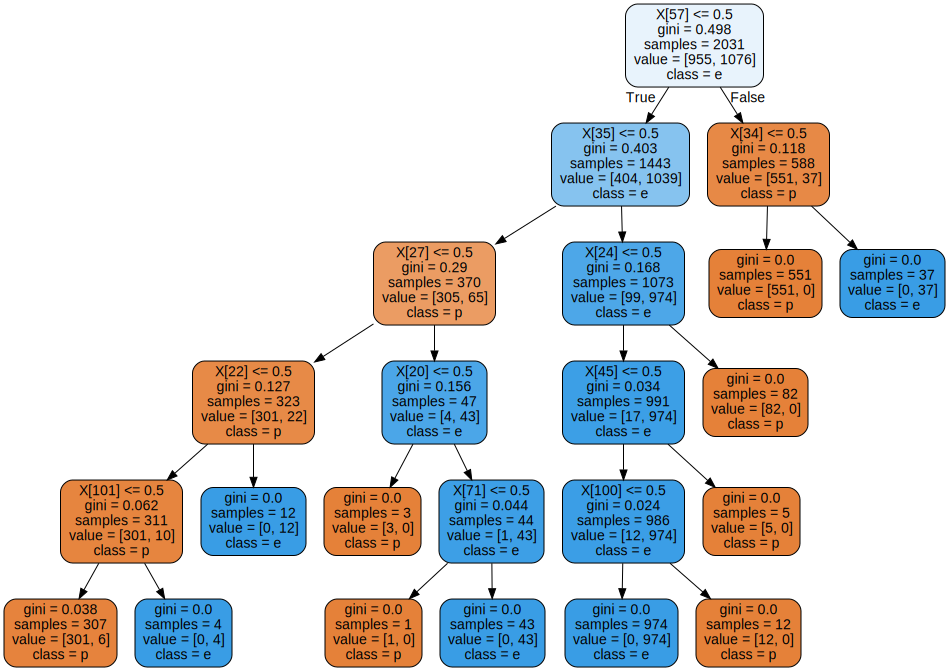

In [71]:
graph

In [74]:
score = clf.score(X_test, Y_test)
prediction = clf.predict(X_test)
precision = metrics.precision_score(Y_test, prediction)
recall = metrics.recall_score(Y_test, prediction)
print('accuracy: ', score)
print('precision: ', precision)
print('recall: ', recall)

accuracy:  1.0
precision:  1.0
recall:  1.0
